# Overview

## Dataset

The dataset includes recorded attributes of four wilderness areas located in the Roosevelt National Forest of northern Colorado. Each observation (i.e record) is a 30m x 30x patch of land. 


## Inference Problem
Predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data). 

Cartographic variables (X) include features such as elevation, soil type, and slope of land. The cover types (Y) include;
1. Spruce/Fir
2. Lodgepole Pine
3. Ponderosa Pine
4. Cottonwood/Willow
5. Aspen
6. Douglas-fir
7. Krummholz

Understanding forest composition is a valuable aspect of managing the health and vitality of our wilderness areas. Classifying cover type can help further research regarding forest fire susceptibility, the spread of the Mountain Pine Beetle infestion, and de-reforestation concerns [[link]](http://cs229.stanford.edu/proj2014/Kevin%20Crain,%20Graham%20Davis,%20Classifying%20Forest%20Cover%20Type%20using%20Cartographic%20Features.pdf).

# Exploratory Data Analysis

In [2]:
import pandas as pd 
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import  GradientBoostingClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC 
from sklearn.neural_network import MLPClassifier

from sklearn import tree

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import json
import pickle
from IPython.display import Image

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

k_folds = 5
%matplotlib inline

In [4]:
# load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv" , header = None)

print("Train data shape: %s" % str(train.shape))
print("Test data shape: %s" % str(test.shape))

Train data shape: (15120, 56)
Test data shape: (565893, 55)


In [5]:
train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [6]:
X = np.array(train)
Y = np.array(train["Cover_Type"].tolist())
shuffle = np.random.permutation(np.arange(X.shape[0]))

X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[13000:], Y[13000:]
dev_data, dev_labels = X[12000:13000], Y[12000:13000]
train_data, train_labels = X[:12000], Y[:12000]
train_df = train.iloc[shuffle,:].iloc[:12000 , :]

data shape:  (15120, 56)
label shape: (15120,)


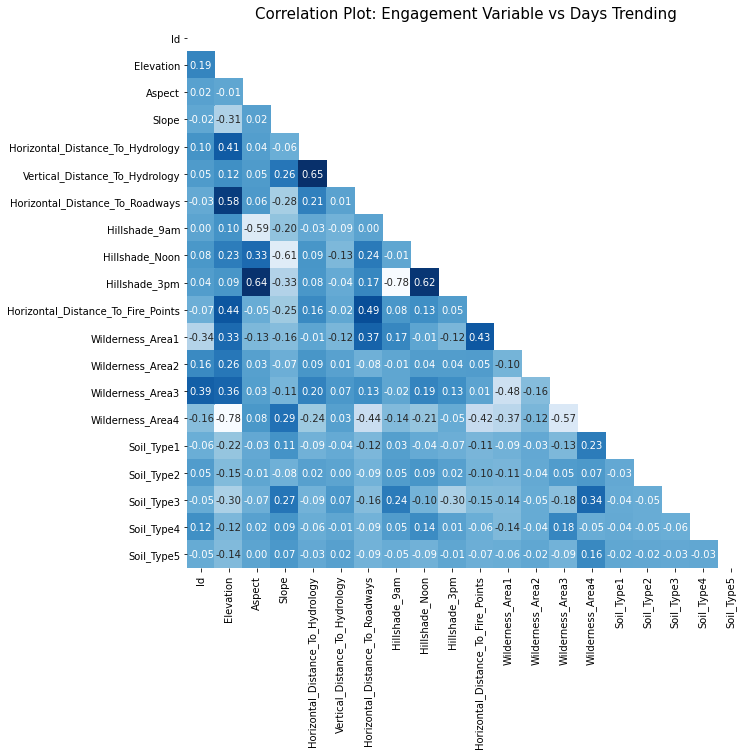

In [20]:
# correlation plot
corr = train_df.iloc[:, 0:20].corr()

# make mask (only plot lower left triangle)
mask = np.ones_like(corr,dtype = np.bool)
mask = np.triu(mask)

# plot the heatmap
fig, ax = plt.subplots(figsize=(10,10))         
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        mask = mask,
        annot=True, 
        fmt='.2f',
        cmap="Blues",
        cbar=False)

plt.title('Correlation Plot: Engagement Variable vs Days Trending',size=15)
plt.show()
pass